# FCT Distribution Comparison Across Different Network Topologies

This notebook compares Flow Completion Time (FCT) distributions for the same network simulation (NS3) across different network topologies (N=4, N=8, N=16).

**Key Insight**: Compare how different network topologies affect FCT distributions to understand the impact of network structure on performance.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## Load FCT Data from Different Topologies

In [6]:
def load_fct_data(filepath):
    """
    Load FCT data from simulation results.
    Format: src_node dst_node src_port dst_port msg_size start_time fct_ns standalone_fct flow_id
    """
    data = []
    with open(filepath, 'r') as f:
        for index, line in enumerate(f):
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 9:
                    # Convert hex src/dst to int, extract key info
                    src = int(parts[0], 16)
                    dst = int(parts[1], 16) 
                    msg_size = int(parts[4])      # Column 5: message size
                    start_time = int(parts[5])    # Column 6: start time
                    fct_ns = int(parts[6])        # Column 7: actual FCT
                    flow_id = int(parts[8])       # Column 9: flow_id (for reference only)
                    data.append([index, fct_ns, src, dst, msg_size, start_time, flow_id])
    
    return pd.DataFrame(data, columns=['original_index', 'fct_ns', 'src_node', 'dst_node', 'msg_size', 'start_time', 'flow_id'])

# Define topology configurations to compare
topologies = {
    'N=4': 'results/ns3_4_8/ns3_fct.txt',
    'N=8': 'results/ns3_8_8/ns3_fct.txt', 
    'N=16': 'results/ns3_16_8/ns3_fct.txt'
}

# Load FCT data for all topologies
print("Loading FCT data for different topologies...")
topo_data = {}
for topo_name, filepath in topologies.items():
    try:
        data = load_fct_data(filepath)
        topo_data[topo_name] = data
        print(f"{topo_name}: {len(data)} flows loaded")
    except FileNotFoundError:
        print(f"Warning: {filepath} not found, skipping {topo_name}")

# Display basic statistics for each topology
print(f"\n📊 FCT Statistics by Topology:")
for topo_name, data in topo_data.items():
    fcts_ms = data['fct_ns'] / 1_000_000  # Convert to milliseconds
    print(f"\n{topo_name}:")
    print(f"  Total flows: {len(data):,}")
    print(f"  FCT mean: {fcts_ms.mean():.3f} ms")
    print(f"  FCT median: {fcts_ms.median():.3f} ms")
    print(f"  FCT std: {fcts_ms.std():.3f} ms")
    print(f"  FCT min: {fcts_ms.min():.3f} ms")
    print(f"  FCT max: {fcts_ms.max():.3f} ms")
    print(f"  FCT P95: {fcts_ms.quantile(0.95):.3f} ms")
    print(f"  FCT P99: {fcts_ms.quantile(0.99):.3f} ms")

# Show message size distribution to verify consistency
print(f"\n📏 Message Size Distribution:")
for topo_name, data in topo_data.items():
    msg_sizes = sorted(data['msg_size'].unique())
    print(f"{topo_name}: {msg_sizes} (unique sizes: {len(msg_sizes)})")

# Check if all topologies have the same message sizes
all_msg_sizes = [set(data['msg_size'].unique()) for data in topo_data.values()]
if len(set(frozenset(s) for s in all_msg_sizes)) == 1:
    print("✅ All topologies have consistent message sizes")
else:
    print("⚠️  Topologies have different message size distributions")

Loading FCT data for different topologies...
N=4: 15360 flows loaded
N=8: 15360 flows loaded
N=16: 15360 flows loaded

📊 FCT Statistics by Topology:

N=4:
  Total flows: 15,360
  FCT mean: 1.025 ms
  FCT median: 0.045 ms
  FCT std: 4.422 ms
  FCT min: 0.003 ms
  FCT max: 33.828 ms
  FCT P95: 2.223 ms
  FCT P99: 28.094 ms

N=8:
  Total flows: 15,360
  FCT mean: 0.742 ms
  FCT median: 0.175 ms
  FCT std: 1.657 ms
  FCT min: 0.003 ms
  FCT max: 6.483 ms
  FCT P95: 5.795 ms
  FCT P99: 5.990 ms

N=16:
  Total flows: 15,360
  FCT mean: 1.675 ms
  FCT median: 0.142 ms
  FCT std: 4.693 ms
  FCT min: 0.003 ms
  FCT max: 33.413 ms
  FCT P95: 10.097 ms
  FCT P99: 28.018 ms

📏 Message Size Distribution:
N=4: [131072, 2097152] (unique sizes: 2)
N=8: [131072, 2097152] (unique sizes: 2)
N=16: [131072, 2097152] (unique sizes: 2)
✅ All topologies have consistent message sizes


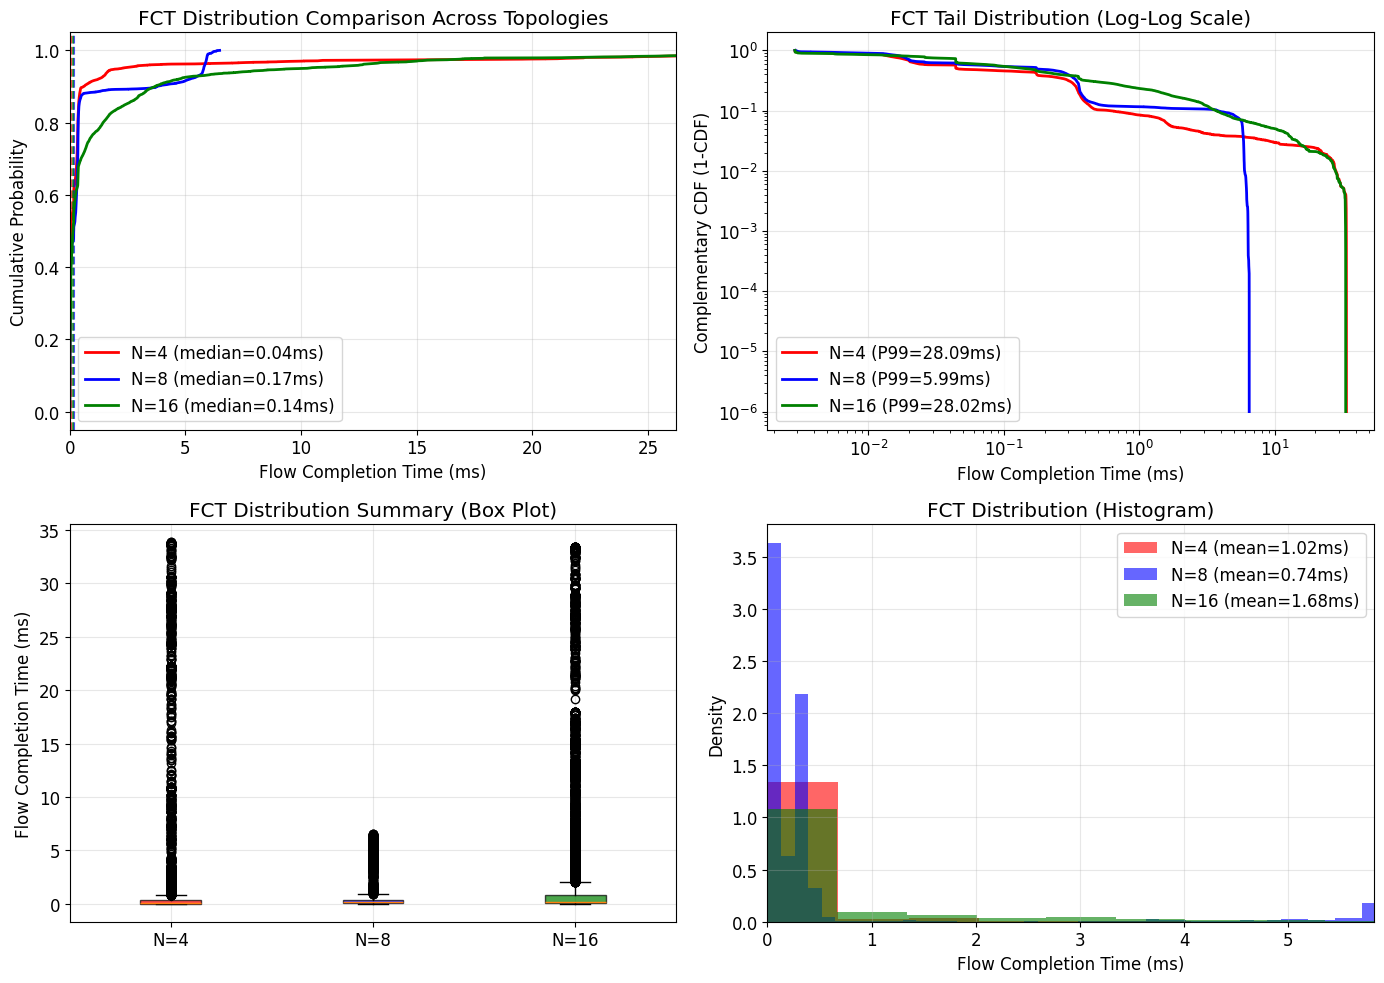

In [7]:
# Create comprehensive FCT distribution plots
colors = {'N=4': 'red', 'N=8': 'blue', 'N=16': 'green'}

# Plot 1: FCT Distribution (CDF)
plt.figure(figsize=(14, 10))

# CDF of FCT values
plt.subplot(2, 2, 1)
for topo_name, data in topo_data.items():
    fcts_ms = data['fct_ns'] / 1_000_000  # Convert to milliseconds
    sorted_fcts = np.sort(fcts_ms)
    cdf_values = np.arange(1, len(sorted_fcts) + 1) / len(sorted_fcts)
    
    plt.plot(sorted_fcts, cdf_values, linewidth=2, color=colors[topo_name], 
             label=f'{topo_name} (median={fcts_ms.median():.2f}ms)')
    
    # Add median line
    median_fct = fcts_ms.median()
    plt.axvline(median_fct, color=colors[topo_name], linestyle='--', alpha=0.7)

plt.xlabel('Flow Completion Time (ms)')
plt.ylabel('Cumulative Probability')
plt.title('FCT Distribution Comparison Across Topologies')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, np.percentile(np.concatenate([data['fct_ns']/1_000_000 for data in topo_data.values()]), 99))

# Plot 2: Log-scale FCT Distribution
plt.subplot(2, 2, 2)
for topo_name, data in topo_data.items():
    fcts_ms = data['fct_ns'] / 1_000_000
    sorted_fcts = np.sort(fcts_ms)
    cdf_values = np.arange(1, len(sorted_fcts) + 1) / len(sorted_fcts)
    
    plt.loglog(sorted_fcts, 1 - cdf_values + 1e-6, linewidth=2, color=colors[topo_name], 
               label=f'{topo_name} (P99={fcts_ms.quantile(0.99):.2f}ms)')

plt.xlabel('Flow Completion Time (ms)')
plt.ylabel('Complementary CDF (1-CDF)')
plt.title('FCT Tail Distribution (Log-Log Scale)')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot 3: Box plot comparison
plt.subplot(2, 2, 3)
fct_data_for_boxplot = []
labels_for_boxplot = []
for topo_name, data in topo_data.items():
    fcts_ms = data['fct_ns'] / 1_000_000
    fct_data_for_boxplot.append(fcts_ms)
    labels_for_boxplot.append(topo_name)

box_plot = plt.boxplot(fct_data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)
for patch, topo_name in zip(box_plot['boxes'], labels_for_boxplot):
    patch.set_facecolor(colors[topo_name])
    patch.set_alpha(0.7)

plt.ylabel('Flow Completion Time (ms)')
plt.title('FCT Distribution Summary (Box Plot)')
plt.grid(True, alpha=0.3)

# Plot 4: Histogram comparison
plt.subplot(2, 2, 4)
for topo_name, data in topo_data.items():
    fcts_ms = data['fct_ns'] / 1_000_000
    plt.hist(fcts_ms, bins=50, alpha=0.6, color=colors[topo_name], 
             label=f'{topo_name} (mean={fcts_ms.mean():.2f}ms)', density=True)

plt.xlabel('Flow Completion Time (ms)')
plt.ylabel('Density')
plt.title('FCT Distribution (Histogram)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, np.percentile(np.concatenate([data['fct_ns']/1_000_000 for data in topo_data.values()]), 95))

plt.tight_layout()
plt.show()


📈 Topology Performance Comparison:

Median FCT Comparison:
  N=4:  0.045 ms (baseline)
  N=8:  0.175 ms (+290.0% vs N=4)
  N=16: 0.142 ms (+216.0% vs N=4)

🏆 Best performing topology: N=4 with median FCT of 0.045 ms

📏 Flow Size Impact Analysis:

N=4:
  128KB flows: median=0.017ms, count=7,680
  2048KB flows: median=0.322ms, count=7,680

N=8:
  128KB flows: median=0.019ms, count=7,680
  2048KB flows: median=0.342ms, count=7,680

N=16:
  128KB flows: median=0.030ms, count=7,680
  2048KB flows: median=0.419ms, count=7,680


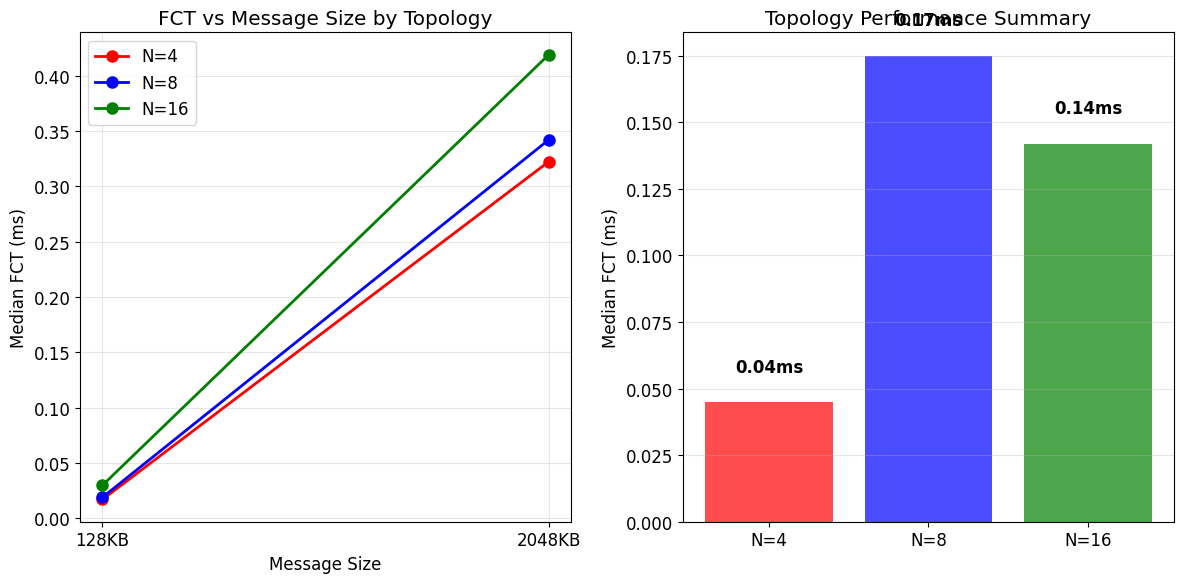

In [8]:
# Additional Analysis: Performance Comparison
print("📈 Topology Performance Comparison:")

# Calculate performance improvement relative to N=4
if 'N=4' in topo_data and 'N=8' in topo_data and 'N=16' in topo_data:
    n4_median = (topo_data['N=4']['fct_ns'] / 1_000_000).median()
    n8_median = (topo_data['N=8']['fct_ns'] / 1_000_000).median()
    n16_median = (topo_data['N=16']['fct_ns'] / 1_000_000).median()
    
    print(f"\nMedian FCT Comparison:")
    print(f"  N=4:  {n4_median:.3f} ms (baseline)")
    print(f"  N=8:  {n8_median:.3f} ms ({((n8_median/n4_median-1)*100):+.1f}% vs N=4)")
    print(f"  N=16: {n16_median:.3f} ms ({((n16_median/n4_median-1)*100):+.1f}% vs N=4)")
    
    # Find the best performing topology
    best_topo = min([('N=4', n4_median), ('N=8', n8_median), ('N=16', n16_median)], key=lambda x: x[1])
    print(f"\n🏆 Best performing topology: {best_topo[0]} with median FCT of {best_topo[1]:.3f} ms")

# Flow size analysis
print(f"\n📏 Flow Size Impact Analysis:")
for topo_name, data in topo_data.items():
    print(f"\n{topo_name}:")
    for msg_size in sorted(data['msg_size'].unique()):
        size_data = data[data['msg_size'] == msg_size]
        fcts_ms = size_data['fct_ns'] / 1_000_000
        size_kb = msg_size // 1024
        print(f"  {size_kb}KB flows: median={fcts_ms.median():.3f}ms, count={len(size_data):,}")

# Create flow size comparison plot
plt.figure(figsize=(12, 6))

# Plot FCT by message size for each topology
plt.subplot(1, 2, 1)
for topo_name, data in topo_data.items():
    size_medians = []
    size_labels = []
    for msg_size in sorted(data['msg_size'].unique()):
        size_data = data[data['msg_size'] == msg_size]
        fcts_ms = size_data['fct_ns'] / 1_000_000
        size_medians.append(fcts_ms.median())
        size_labels.append(f"{msg_size//1024}KB")
    
    plt.plot(size_labels, size_medians, 'o-', linewidth=2, markersize=8,
             color=colors[topo_name], label=topo_name)

plt.xlabel('Message Size')
plt.ylabel('Median FCT (ms)')
plt.title('FCT vs Message Size by Topology')
plt.grid(True, alpha=0.3)
plt.legend()

# Performance summary bar chart
plt.subplot(1, 2, 2)
if 'N=4' in topo_data and 'N=8' in topo_data and 'N=16' in topo_data:
    topologies_list = ['N=4', 'N=8', 'N=16']
    medians = [n4_median, n8_median, n16_median]
    
    bars = plt.bar(topologies_list, medians, color=[colors[t] for t in topologies_list], alpha=0.7)
    
    # Add value labels on bars
    for bar, median in zip(bars, medians):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{median:.2f}ms', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('Median FCT (ms)')
    plt.title('Topology Performance Summary')
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
